In [1]:
import pandas as pd
from warnings import simplefilter

simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
from pathlib import Path
import json
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from datetime import datetime
import re
from scipy import stats
from scipy.optimize import curve_fit
import numpy as np
import statsmodels.api as sm
from matplotlib import colormaps
from tqdm.notebook import tqdm
import helpers
from sklearn.metrics import r2_score
from IPython.display import clear_output
import textwrap
from statsmodels.stats.outliers_influence import variance_inflation_factor

# from reload_recursive import reload_recursive
from statsmodels.stats.mediation import Mediation
from statsmodels.genmod.families import Poisson
import pyperclip

from mri_data import file_manager as fm

In [2]:
# reload_recursive(helpers)

## Load Data

### Clinical and Volumes

### HIPS-THOMAS Volumes and Distances

In [119]:
drive_root = fm.get_drive_root()
dataroot = drive_root / "3Tpioneer_bids"
data_dir = Path("/home/srs-9/Projects/ms_mri/data")
fig_path = Path(
    "/home/srs-9/Projects/ms_mri/analysis/thalamus/figures_tables/choroid_associations"
)

choroid_volumes = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/choroid_aschoplex_volumes.csv", index_col="subid"
)
ventricle_volumes = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/analysis/paper1/data0/ventricle_volumes.csv",
    index_col="subid",
)
csf_volumes = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/analysis/thalamus/data0/csf_volumes.csv",
    index_col="subid",
)
third_ventricle_width = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/analysis/thalamus/data0/third_ventricle_width.csv",
    index_col="subid",
)

tiv = pd.read_csv("/home/srs-9/Projects/ms_mri/data/tiv_data.csv", index_col="subid")

df = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/clinical_data_processed.csv", index_col="subid"
)
sdmt = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/analysis/thalamus/SDMT_sheet.csv", index_col="subid"
)
df = df.join([choroid_volumes, tiv, ventricle_volumes, sdmt["SDMT"]])
df["periCSF"] = csf_volumes["peripheral"]
df["allCSF"] = csf_volumes["all"]
df["thirdV"] = csf_volumes["third_ventricle"]

df["thirdV_width"] = third_ventricle_width["third_ventricle_width"]
df["periCSF_frac"] = csf_volumes["peripheral"] / csf_volumes["all"]
df.rename(columns={'ventricle_volume': 'LV', 'choroid_volume': 'CP'}, inplace=True)

df["SDMT"] = pd.to_numeric(df["SDMT"], errors="coerce")
df["thalamus_sqrt"] = np.sqrt(df["thalamus"])
df["thalamus_curt"] = np.sqrt(df["thalamus"] ** 3)
df["cortical_thickness_inv"] = 1 / df["cortical_thickness"]
df["LV_logtrans"] = np.log(df["LV"])

# these corrections should ultimately be made to the csf file
for struct in ["brain", "white", "grey", "thalamus", "t2lv"]:
    df[struct] = df[struct] * 1000

df["CCF"] = df["LV"] / df["allCSF"]
df["peri_ratio"] = df["periCSF"] / df["LV"]


df_z = df.copy()
numeric_cols = df.select_dtypes(include="number").columns
df_z[numeric_cols] = df_z[numeric_cols].apply(stats.zscore, nan_policy="omit")

viridis = colormaps["viridis"].resampled(20)

colors = helpers.get_colors()

In [4]:
df_thomas = pd.read_csv(data_dir / "hipsthomas_vols.csv", index_col="subid")
cols_orig = df_thomas.columns
new_colnames = {}
for col in df_thomas.columns:
    new_col = re.sub(r"(\d+)-([\w-]+)", r"\2_\1", col)
    new_col = re.sub("-", "_", new_col)
    new_colnames[col] = new_col
df_thomas = df_thomas.rename(columns=new_colnames)
df_thomas_z = df_thomas.apply(stats.zscore, nan_policy="omit")

df_thomas_left = pd.read_csv(data_dir / "hipsthomas_left_vols.csv", index_col="subid")
df_thomas_left = df_thomas_left.rename(columns=new_colnames)
df_thomas_left_z = df_thomas_left.apply(stats.zscore, nan_policy="omit")

df_thomas_right = pd.read_csv(data_dir / "hipsthomas_right_vols.csv", index_col="subid")
df_thomas_right = df_thomas_right.rename(columns=new_colnames)
df_thomas_right_z = df_thomas_right.apply(stats.zscore, nan_policy="omit")


thalamic_nuclei = [2, 4, 5, 6, 7, 8, 9, 10, 11, 12]
deep_grey = [13, 14, 26, 27, 28, 29, 30, 31, 32]

ignore_structs1 = [
    "THALAMUS_1",
    "Amy_34",
    "GP_33",
    "Cla_28",
    "Acc_26",
    "Hb_13",
    "MTT_14",
]
ignore_structs2 = ["THALAMUS_1", "Amy_34", "GP_33", "Hb_13", "MTT_14"]

thalamic_nuclei_str = [str(i) for i in thalamic_nuclei]

hips_thomas_ref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="index"
)["struct"]
hips_thomas_invref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="struct"
)["index"]


def combine_nuclei(df):
    df2 = pd.DataFrame()
    df2["anterior"] = df["AV_2"]
    df2["ventral"] = df["VA_4"] + df["VLa_5"] + df["VLP_6"] + df["VPL_7"]
    df2["intralaminar"] = df["CM_11"]
    df2["medial"] = df["MD_Pf_12"]
    df2["posterior"] = df["Pul_8"] + df["LGN_9"] + df["MGN_10"]
    df2["THALAMUS_1"] = df["THALAMUS_1"]
    return df2


def combine_nuclei2(df):
    df2 = pd.DataFrame()
    df2["anterior"] = df["AV_2"]
    df2["ventral"] = df["VA_4"] + df["VLa_5"] + df["VLP_6"] + df["VPL_7"]
    df2["medial"] = df["MD_Pf_12"] + df["CM_11"]
    df2["posterior"] = df["Pul_8"] + df["LGN_9"] + df["MGN_10"]
    df2["THALAMUS_1"] = df["THALAMUS_1"]
    return df2


df_thomas2 = combine_nuclei2(df_thomas)
grouped_nuclei = df_thomas2.columns[~df_thomas2.columns.isin(["THALAMUS_1"])]
df_thomas2_z = df_thomas2.apply(stats.zscore, nan_policy="omit")

df_thomas2_left = combine_nuclei2(df_thomas_left)
df_thomas2_left_z = df_thomas2_left.apply(stats.zscore, nan_policy="omit")

df_thomas2_right = combine_nuclei2(df_thomas_right)
df_thomas2_right_z = df_thomas2_right.apply(stats.zscore, nan_policy="omit")

In [5]:
df["t2lv"]

subid
1001     1433.965228
1002     1197.262277
1003     1896.614470
1004     1099.200521
1005     2645.443695
            ...     
3016     1205.552968
3017    10415.873200
3021     2186.487423
3023     4893.520521
3028     3990.667828
Name: t2lv, Length: 564, dtype: float64

## Functions

In [6]:
def normalize_by_tiv(df, variables=None):
    if variables is None:
        variables = [
            "brain",
            "white",
            "grey",
            "csf_all",
            "csf_peripheral",
            "ventricle_volume",
            "choroid_volume",
        ]

    for var in variables:
        new_var = f"n-{var}"
        df[new_var] = df[var] / df["tiv"]

    return df


def zscore(df):
    df_z = df.copy()
    numeric_cols = df.select_dtypes(include="number").columns
    df_z[numeric_cols] = df_z[numeric_cols].apply(stats.zscore, nan_policy="omit")
    return df_z

## Analysis

### Exploratory Stuff

                            OLS Regression Results                            
Dep. Variable:       ventricle_volume   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     240.8
Date:                Sat, 25 Oct 2025   Prob (F-statistic):           4.67e-44
Time:                        22:42:09   Log-Likelihood:                -5059.2
No. Observations:                 467   AIC:                         1.012e+04
Df Residuals:                     465   BIC:                         1.013e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -5.441e+04   5044.560    -10.787      0.0

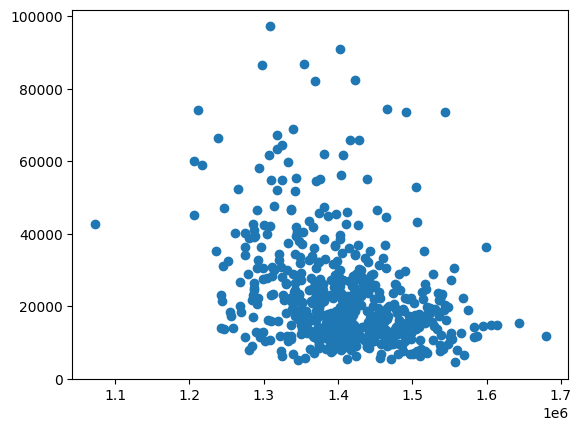

In [7]:
work_data = df[df["dz_type2"] == "MS"]
modelA = sm.OLS.from_formula("ventricle_volume ~ csf_all", data=work_data).fit()
modelB = sm.OLS.from_formula(
    "ventricle_volume ~ csf_all + brain + age + Female + tiv", data=work_data
).fit()
print(modelA.summary())
print(modelB.summary())

work_data["DVE"] = modelA.resid
plt.scatter(df["brain"], df["ventricle_volume"])

In [121]:
model_data = df_z.join([df_thomas2_z])
model_data = model_data[model_data["dz_type2"] == "MS"]

formula = "LV ~ THALAMUS_1 + periCSF + Female + tiv"
result = sm.OLS.from_formula(formula, data=model_data).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                     LV   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                     113.9
Date:                Sun, 26 Oct 2025   Prob (F-statistic):           1.64e-67
Time:                        02:38:37   Log-Likelihood:                -513.11
No. Observations:                 467   AIC:                             1036.
Df Residuals:                     462   BIC:                             1057.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0183      0.034     -0.538      0.5

In [184]:
model_data = df.join([df_thomas2])
model_data = model_data[model_data["dz_type2"] == "MS"]

formula = "LV ~ CP + age + Female + tiv"
# formula = "THALAMUS_1 ~ periCSF + age + Female + tiv"

result = sm.OLS.from_formula(formula, data=model_data).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                     LV   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.382
Method:                 Least Squares   F-statistic:                     73.03
Date:                Sun, 26 Oct 2025   Prob (F-statistic):           6.34e-48
Time:                        03:20:17   Log-Likelihood:                -5042.2
No. Observations:                 467   AIC:                         1.009e+04
Df Residuals:                     462   BIC:                         1.012e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -4.908e+04   8907.656     -5.510      0.0

LV ~ (0.10)periCSF
LV ~ (0.12)periCSF +  (-4.77)Thal
LV ~ (0.06)periCSF + (0.017)TIV
LV ~ (-0.09)periCSF + (-6.96)Thal + (0.08)TIV

In [170]:
formula = "EDSS ~ THALAMUS_1 + age + Female + tiv"
# formula = "THALAMUS_1 ~ CP + age + Female + tiv"

result = sm.OLS.from_formula(formula, data=model_data).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   EDSS   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     1.098
Date:                Sun, 26 Oct 2025   Prob (F-statistic):              0.370
Time:                        03:09:55   Log-Likelihood:                -86.720
No. Observations:                  46   AIC:                             183.4
Df Residuals:                      41   BIC:                             192.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.7127      4.932      1.969      0.0

In [ ]:
model_data = df_z.join([df_thomas_z])
model_data = model_data[model_data["dz_type3"] == "MS"]

formula = "ventricle_volume ~ csf_all + choroid_volume + age + Female + tiv"
result = sm.OLS.from_formula(formula, data=model_data).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:       ventricle_volume   R-squared:                       0.478
Model:                            OLS   Adj. R-squared:                  0.472
Method:                 Least Squares   F-statistic:                     84.31
Date:                Sat, 25 Oct 2025   Prob (F-statistic):           8.60e-63
Time:                        17:19:18   Log-Likelihood:                -521.71
No. Observations:                 467   AIC:                             1055.
Df Residuals:                     461   BIC:                             1080.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0222      0.035      0.

### Relative effect size

Compare influence of thalamic nuclei volumes on LV volume.

Define a model for each nucleus to regress out peripheral CSF volume, age, sex, and TIV. Do the same for LV volume. Then get Pearson r for each set of residuals to do the Williams-Hotelling test. 

The following produces R code which I copy into Rstudio.

The trend I find is not specific to MS, so what does this mean.

In [194]:
model_data = df.join([df_thomas2])

disease_group = "NIND"
model_data = model_data[model_data["dz_type5"] == disease_group]

models = {}
models["medial"] = sm.OLS.from_formula(
    "medial ~ periCSF + age + Female + tiv", data=model_data
).fit()
models["posterior"] = sm.OLS.from_formula(
    "posterior ~ periCSF + age + Female + tiv", data=model_data
).fit()
models["anterior"] = sm.OLS.from_formula(
    "anterior ~ periCSF + age + Female + tiv", data=model_data
).fit()
models["ventral"] = sm.OLS.from_formula(
    "ventral ~ periCSF + age + Female + tiv", data=model_data
).fit()
models["THALAMUS_1"] = sm.OLS.from_formula(
    "THALAMUS_1 ~ periCSF + age + Female + tiv", data=model_data
).fit()
models["LV"] = sm.OLS.from_formula(
    "LV ~ periCSF + age + Female + tiv", data=model_data
).fit()

nobs = models["LV"].nobs

structs = ["posterior", "medial", "anterior", "ventral"]
working_structs = structs.copy()

R_cmd = "# Regressing LV residuals controlling for peripheral CSF volume\n\nresult_text <- ''\n"
pearson_results = {}
for i, struct1 in enumerate(structs):
    working_structs = working_structs[1:]
    for struct2 in working_structs:
        p1, pval1 = stats.pearsonr(models[struct1].resid, models["LV"].resid)
        pearson_results[struct1] = (p1, pval1)
        p2, pval2 = stats.pearsonr(models[struct2].resid, models["LV"].resid)
        pearson_results[struct2] = (p2, pval2)
        p12, pval12 = stats.pearsonr(models[struct1].resid, models[struct2].resid)

        if abs(p1) > abs(p2):
            sign = ">"
        else:
            sign = "<"
        R_cmd += textwrap.dedent(f"""
        comparison <- '{struct1} {sign} {struct2}'
        p <- test2r.t2({p1:0.3}, {p2:0.3}, {p12:0.3}, {nobs})$p_value
        result_text <- paste(result_text, sprintf("%s, p=%.2e", comparison, p), sep='\\n')
        """)

R_cmd += "\ncat(result_text)\n"

pearson_results["THALAMUS_1"] = stats.pearsonr(
    models["THALAMUS_1"].resid, models["LV"].resid
)

# Medial has a stronger association than THALAMUS_1, so just test this one
p1 = pearson_results["THALAMUS_1"][0]
p2 = pearson_results["medial"][0]
p12 = stats.pearsonr(models["medial"].resid, models["THALAMUS_1"].resid).statistic
comparison = "'medial > THALAMUS_1'"
R_cmd += (
    f"comparison <- {comparison}\n" 
    f"p <- test2r.t2({p1:0.3}, {p2:0.3}, {p12:0.3}, {nobs})$p_value\n" 
    f"result_text <- sprintf(\"%s, p=%.2e\", comparison, p)"
)

pyperclip.copy(R_cmd)

print(f"Disease group: {disease_group}")
for struct in ["THALAMUS_1"] + structs:
    print(
        f"struct: {struct}, r: {pearson_results[struct][0]:0.3}, pval: {pearson_results[struct][1]:0.3}"
    )

Disease group: NIND
struct: THALAMUS_1, r: -0.373, pval: 0.00825
struct: posterior, r: -0.408, pval: 0.00359
struct: medial, r: -0.409, pval: 0.0035
struct: anterior, r: -0.258, pval: 0.0735
struct: ventral, r: -0.0886, pval: 0.545


struct: THALAMUS_1, r: -0.636, pval: 2.12e-54  
struct: posterior, r: -0.606, pval: 3.21e-48  
struct: medial, r: -0.669, pval: 5.82e-62  
struct: anterior, r: -0.369, pval: 1.63e-16  
struct: ventral, r: -0.448, pval: 1.78e-24

Williams-Hotelling tests above were run in R and gave the following results:

- `posterior < medial, p=7.41e-04`  
- `posterior > anterior, p=1.85e-12`  
- `posterior > ventral, p=4.51e-08`  
- `medial > anterior, p=2.47e-19`  
- `medial > ventral, p=7.05e-17`  

The medial nuclei are the only ones with a stronger beta than that of whole thalamus

- `medial > THALAMUS_1, p=1.70e-02`

Then to do one more check, put all in one model.

In [103]:
model_combined = sm.OLS.from_formula(
    """ventricle_volume ~ medial + posterior + anterior + ventral + 
       THALAMUS_1 + csf_peripheral + age + Female + tiv""",
    data=model_data
).fit()

print(model_combined.summary())

                            OLS Regression Results                            
Dep. Variable:       ventricle_volume   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.593
Method:                 Least Squares   F-statistic:                     76.45
Date:                Sat, 25 Oct 2025   Prob (F-statistic):           1.93e-85
Time:                        16:49:30   Log-Likelihood:                -4942.2
No. Observations:                 467   AIC:                             9904.
Df Residuals:                     457   BIC:                             9946.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -1.642e+04   7427.455     -2.

In [122]:
model_data = work_data.join([df_thomas2])
model_data = zscore(model_data)

model = sm.OLS.from_formula(
    "ventricle_volume ~ csf_peripheral + choroid_volume + THALAMUS_1 + age + Female + tiv",
    data=model_data,
).fit()
print(model.summary())

NameError: name 'work_data' is not defined

Ventricle volume as outcome, csf_peripheral is not significant while white is a covariate, but choroid volume is. Grey isnt important

### Mediation

In [129]:
model_data = df_z.join([df_thomas2_z])
model_data = model_data[model_data["dz_type2"] == "MS"]

from pyprocessmacro import Process

p2 = Process(data=model_data, model=4, x="choroid_volume", y="ventricle_volume",
            m=["THALAMUS_1", "csf_all"],
            controls=["age", "Female", "tiv"],
            controls_in="all")
p2.summary()

Process successfully initialized.
Based on the Process Macro by Andrew F. Hayes, Ph.D. (www.afhayes.com)


****************************** SPECIFICATION ****************************

Model = 4

Variables:
    Cons = Cons
    x = choroid_volume
    y = ventricle_volume
    m1 = THALAMUS_1
    m2 = csf_all
Statistical Controls:
 age, Female, tiv



Sample size:
468

Bootstrapping information for indirect effects:
Final number of bootstrap samples: 5000
Number of samples discarded due to convergence issues: 0

***************************** OUTCOME MODELS ****************************

Outcome = ventricle_volume 
OLS Regression Summary

     R²  Adj. R²    MSE       F  df1  df2  p-value
 0.5614   0.5547 0.4662 98.1310    6  460   0.0000

Coefficients

                 coeff     se       t      p    LLCI    ULCI
Cons           -0.0011 0.0318 -0.0337 0.9731 -0.0634  0.0612
choroid_volume  0.1933 0.0408  4.7365 0.0000  0.1133  0.2733
age             0.1000 0.0363  2.7538 0.0061  0.0288  0.1712


/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:752: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  llci, ulci = bias_corrected_ci(e, be, conf)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:827: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  ci = bias_corrected_ci(e[i], be[i], conf)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:1222: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch 

In [109]:
p2 = Process(data=model_data, model=4, x="choroid_volume", y="THALAMUS_1",
            m=["ventricle_volume"],
            controls=["age", "Female", "tiv"],
            controls_in="all")
p2.summary()

Process successfully initialized.
Based on the Process Macro by Andrew F. Hayes, Ph.D. (www.afhayes.com)


****************************** SPECIFICATION ****************************

Model = 4

Variables:
    Cons = Cons
    x = choroid_volume
    y = THALAMUS_1
    m1 = ventricle_volume
Statistical Controls:
 age, Female, tiv



Sample size:
468

Bootstrapping information for indirect effects:
Final number of bootstrap samples: 5000
Number of samples discarded due to convergence issues: 0

***************************** OUTCOME MODELS ****************************

Outcome = THALAMUS_1 
OLS Regression Summary

     R²  Adj. R²          MSE        F  df1  df2  p-value
 0.5776   0.5720 1154905.9165 126.0550    5  461   0.0000

Coefficients

                    coeff       se        t      p       LLCI      ULCI
Cons             225.1544 831.1034   0.2709 0.7866 -1403.7783 1854.0871
choroid_volume    -0.6511   0.1234  -5.2785 0.0000    -0.8929   -0.4094
age               -8.2519   4.5302  -

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:752: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  llci, ulci = bias_corrected_ci(e, be, conf)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:827: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  ci = bias_corrected_ci(e[i], be[i], conf)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:1222: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch 